# XGBoost

## インポート

In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier
from xgboost import plot_importance

## ロード

In [6]:
airline_data = pd.read_csv('data/Invistico_Airline.csv')
airline_data.head(10)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,2,4,5,3,4,2,30,26.0


In [7]:
airline_data_dummies = pd.get_dummies(airline_data, 
                                         columns=['satisfaction','Customer Type','Type of Travel','Class'])

## トレーニング、テストデータ

In [9]:
y = airline_data_dummies['satisfaction_satisfied'] 
X = airline_data_dummies.drop(['satisfaction_satisfied','satisfaction_dissatisfied'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## XGBoostモデル

In [12]:
# バイナリ予測
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }
scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = list(scoring),
                      cv = 5,
                      refit = 'f1'
                     )

In [13]:
%%time
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: total: 18min 20s
Wall time: 49.3 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring=['f1', 'recall', 'accuracy', 'precision'])

## モデルの保存

In [14]:
pickle.dump(xgb_cv, open('xgb_cv.sav', 'wb'))

### 参考：モデルの読み込み

In [ ]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

## 予測

In [15]:
y_pred = xgb_cv.predict(X_test)

In [16]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)
pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)
rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)
f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.9296889436402833
precision score: 0.9413165504337473
recall score: 0.9300840336134454
f1 score: 0.9356665821286668


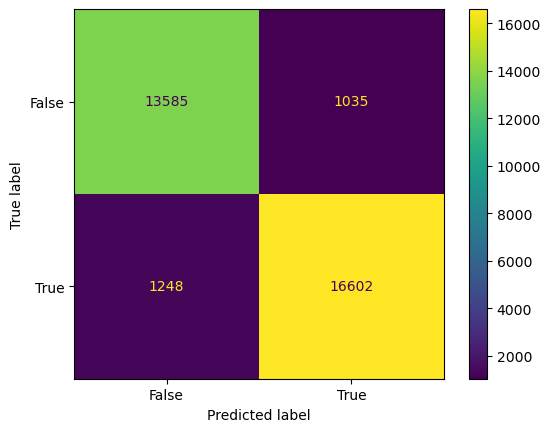

In [17]:
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv.classes_)
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

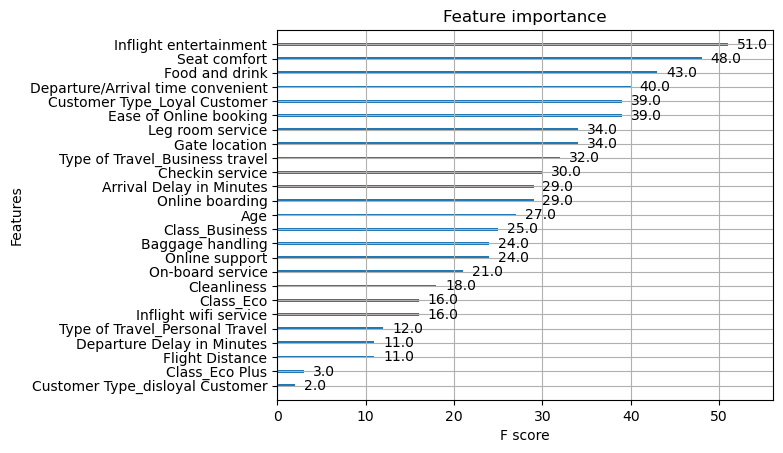

In [18]:
plot_importance(xgb_cv.best_estimator_)